In [ ]:
!pip install rasterio
!pip install pycocotools # for the binary mask generation
!pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 27.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 26.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=4d3276f778dbe5ae1e98511fdf85c3a02ca6877a6b556d5d96b64aa4f5d61697
  Stored in directory: /root/.cache/pip

In [ ]:
## Importing the libraries 
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from pathlib import Path, fnmatch

from pdb import set_trace
from sklearn.model_selection import train_test_split

import json
from pycocotools import mask as maskUtils # 
import cv2
import albumentations as A


import time
import os
from tqdm.notebook import tqdm


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Using pretrained models 

In [ ]:
#Using the segmentaion models from pytorch 


## Training a costum model for multiclass classification semantic classification 

In [ ]:
class DroneDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        


        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
            
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = transforms.Compose([transforms.ToTensor(), transforms.Normalize(self.mean, self.std)])
        img = t(img)
        
        mask = torch.from_numpy(mask).long()

        
        if self.patches:
            img, mask = self.tiles(img, mask)
        return img, mask
    
  
    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)

        img_patches  = img_patches.contiguous().view(3,-1, 512, 768)

        img_patches = img_patches.permute(1,0,2,3)

        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

In [ ]:
MASK_PATH  = '/content/drive/MyDrive/Hack23/images/dataset/semantic_drone_dataset/label_images_semantic/'
IMAGE_PATH = '/content/drive/MyDrive/Hack23/images/dataset/semantic_drone_dataset/original_images/'

### Quick update for Daniel. We trained the model for multitclass segmentation. There were some confusion in the explanation, meaning instance segmentation and semantic segmentation. 

1. For binary sematic segmantation that was clear the target is just 0 and 1, where 1 represent our selected class
2. For multiclass semantic segmentation, the label images is composed has a dimension of [H,W,1] like in the binary case, but here instead of just 0 and 1 as pixel values, we have [0,1,2,...,class_n], where each pixel represent a unique class (ie. 0= nothing, 1=trees, 2=asphalt, etc ... ]. To ilustrate that let's run some code

In [ ]:
testing_mask = os.path.join(MASK_PATH + '000.png')
testing_image = os.path.join(IMAGE_PATH+ '000.jpg')

In [ ]:
def im_read(path):
    image = Image.open(path)
    return np.array(image)

img_test_mask =  im_read(testing_mask)
img_test_oring =  im_read(testing_image)

In [ ]:
#### We can see output array([ 0,  1,  2,  4,  8, 10, 15, 19, 22], dtype=uint8)
np.unique(img_test_mask)

array([ 0,  1,  2,  4,  8, 10, 15, 19, 22], dtype=uint8)

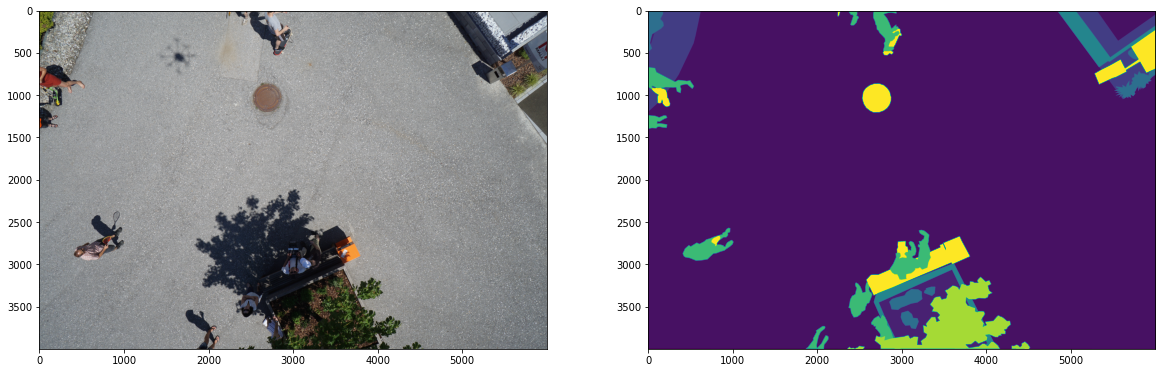

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,20))
ax[0].imshow(img_test_oring)
ax[1].imshow(img_test_mask)

In [ ]:
test_class1 = np.where(img_test_mask==1, 1, 0)
test_class2 = np.where(img_test_mask==2, 1, 0)
test_class3 = np.where(img_test_mask==3, 1, 0)
test_class4 = np.where(img_test_mask==4, 1, 0)

In [ ]:
test_class1.shape

(4000, 6000)

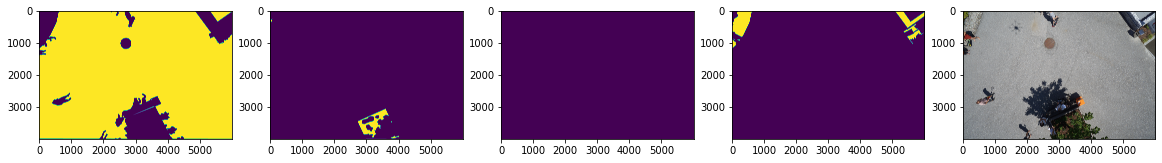

In [ ]:
fig, ax = plt.subplots(1,5, figsize=(20,20))
ax[0].imshow(test_class1)
ax[1].imshow(test_class2)
ax[2].imshow(test_class3)
ax[3].imshow(test_class4)
ax[4].imshow(img_test_oring)

In [ ]:
n_classes = 23 
def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  400


In [ ]:
#split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  306
Val Size     :  54
Test Size    :  40


In [ ]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 1

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [ ]:
a,b = train_set[0]

In [ ]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False, model_type='Unet'):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device)
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    # torch.save(model, 'Unet_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    torch.save({
                                'epoch': e,
                                'model_state_dict': model.state_dict(),
                                'loss': min_loss,
                                },'/content/drive/MyDrive/Hack23/costum_models/'+model_type+'-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                                        

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [ ]:

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64)) 
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [ ]:
model_new = UNet(n_channels=3, n_classes=1, bilinear=False)

In [ ]:
max_lr = 1e-3
epoch = 30
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_new.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model_new, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/306 [00:00<?, ?it/s]

In [ ]:
##################################################################################
#SegNet: A Deep Convolutional Encoder-Decoder Architecture for Image Segmentation
#Paper-Link: https://arxiv.org/pdf/1511.00561.pdf
##################################################################################


import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary



__all__ = ["SegNet"]

class SegNet(nn.Module):
    def __init__(self,classes= 19):
        super(SegNet, self).__init__()

        batchNorm_momentum = 0.1

        self.conv11 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)
        self.conv12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(128, momentum= batchNorm_momentum)
        self.conv22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(128, momentum= batchNorm_momentum)

        self.conv31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(256, momentum= batchNorm_momentum)
        self.conv32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(256, momentum= batchNorm_momentum)
        self.conv33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn33 = nn.BatchNorm2d(256, momentum= batchNorm_momentum)

        self.conv41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn43 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)

        self.conv51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn51 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn52 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn53 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)

        self.conv53d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn53d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv52d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn52d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv51d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn51d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)

        self.conv43d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn43d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv42d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn42d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv41d = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn41d = nn.BatchNorm2d(256, momentum= batchNorm_momentum)

        self.conv33d = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn33d = nn.BatchNorm2d(256, momentum= batchNorm_momentum)
        self.conv32d = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn32d = nn.BatchNorm2d(256, momentum= batchNorm_momentum)
        self.conv31d = nn.Conv2d(256,  128, kernel_size=3, padding=1)
        self.bn31d = nn.BatchNorm2d(128, momentum= batchNorm_momentum)

        self.conv22d = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn22d = nn.BatchNorm2d(128, momentum= batchNorm_momentum)
        self.conv21d = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn21d = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv12d = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn12d = nn.BatchNorm2d(64, momentum= batchNorm_momentum)
        self.conv11d = nn.Conv2d(64, classes, kernel_size=3, padding=1)


    def forward(self, x):

        # Stage 1
        x11 = F.relu(self.bn11(self.conv11(x)))
        x12 = F.relu(self.bn12(self.conv12(x11)))
        x1_size = x12.size()
        x1p, id1 = F.max_pool2d(x12,kernel_size=2, stride=2,return_indices=True)

        # Stage 2
        x21 = F.relu(self.bn21(self.conv21(x1p)))
        x22 = F.relu(self.bn22(self.conv22(x21)))
        x2_size = x22.size()
        x2p, id2 = F.max_pool2d(x22,kernel_size=2, stride=2,return_indices=True)

        # Stage 3
        x31 = F.relu(self.bn31(self.conv31(x2p)))
        x32 = F.relu(self.bn32(self.conv32(x31)))
        x33 = F.relu(self.bn33(self.conv33(x32)))
        x3_size = x33.size()
        x3p, id3 = F.max_pool2d(x33,kernel_size=2, stride=2,return_indices=True)

        # Stage 4
        x41 = F.relu(self.bn41(self.conv41(x3p)))
        x42 = F.relu(self.bn42(self.conv42(x41)))
        x43 = F.relu(self.bn43(self.conv43(x42)))
        x4_size = x43.size()
        x4p, id4 = F.max_pool2d(x43,kernel_size=2, stride=2,return_indices=True)

        # Stage 5
        x51 = F.relu(self.bn51(self.conv51(x4p)))
        x52 = F.relu(self.bn52(self.conv52(x51)))
        x53 = F.relu(self.bn53(self.conv53(x52)))
        x5_size = x53.size()
        x5p, id5 = F.max_pool2d(x53,kernel_size=2, stride=2,return_indices=True)


        # Stage 5d
        x5d = F.max_unpool2d(x5p, id5, kernel_size=2, stride=2, output_size=x5_size)
        x53d = F.relu(self.bn53d(self.conv53d(x5d)))
        x52d = F.relu(self.bn52d(self.conv52d(x53d)))
        x51d = F.relu(self.bn51d(self.conv51d(x52d)))

        # Stage 4d
        x4d = F.max_unpool2d(x51d, id4, kernel_size=2, stride=2, output_size=x4_size)
        x43d = F.relu(self.bn43d(self.conv43d(x4d)))
        x42d = F.relu(self.bn42d(self.conv42d(x43d)))
        x41d = F.relu(self.bn41d(self.conv41d(x42d)))

        # Stage 3d
        x3d = F.max_unpool2d(x41d, id3, kernel_size=2, stride=2, output_size=x3_size)
        x33d = F.relu(self.bn33d(self.conv33d(x3d)))
        x32d = F.relu(self.bn32d(self.conv32d(x33d)))
        x31d = F.relu(self.bn31d(self.conv31d(x32d)))

        # Stage 2d
        x2d = F.max_unpool2d(x31d, id2, kernel_size=2, stride=2, output_size=x2_size)
        x22d = F.relu(self.bn22d(self.conv22d(x2d)))
        x21d = F.relu(self.bn21d(self.conv21d(x22d)))

        # Stage 1d
        x1d = F.max_unpool2d(x21d, id1, kernel_size=2, stride=2, output_size=x1_size)
        x12d = F.relu(self.bn12d(self.conv12d(x1d)))
        x11d = self.conv11d(x12d)

        return x11d

    def load_from_segnet(self, model_path):
        s_dict = self.state_dict()# create a copy of the state dict
        th = torch.load(model_path).state_dict() # load the weigths
        # for name in th:
            # s_dict[corresp_name[name]] = th[name]
        self.load_state_dict(th)



# """print layers and params of network"""
# if __name__ == '__main__':
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model = SegNet(classes=19).to(device)
#     summary(model,(3,512,1024))

In [ ]:
model  = SegNet(classes=23).to(device)

In [ ]:
max_lr = 1e-3
epoch = 30
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/306 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 1.915 
Epoch:1/30.. Train Loss: 2.213.. Val Loss: 1.915.. Train mIoU:0.074.. Val mIoU: 0.071.. Train Acc:0.397.. Val Acc:0.417.. Time: 22.90m


  0%|          | 0/306 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:2/30.. Train Loss: 1.836.. Val Loss: 2.017.. Train mIoU:0.086.. Val mIoU: 0.080.. Train Acc:0.463.. Val Acc:0.452.. Time: 7.53m


  0%|          | 0/306 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Loss Decreasing.. 2.017 >> 1.760 
Epoch:3/30.. Train Loss: 1.767.. Val Loss: 1.760.. Train mIoU:0.095.. Val mIoU: 0.082.. Train Acc:0.487.. Val Acc:0.477.. Time: 7.74m


  0%|          | 0/306 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:4/30.. Train Loss: 1.689.. Val Loss: 1.886.. Train mIoU:0.100.. Val mIoU: 0.080.. Train Acc:0.502.. Val Acc:0.447.. Time: 7.56m


  0%|          | 0/306 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Loss Decreasing.. 1.886 >> 1.876 
Epoch:5/30.. Train Loss: 1.675.. Val Loss: 1.876.. Train mIoU:0.103.. Val mIoU: 0.072.. Train Acc:0.505.. Val Acc:0.437.. Time: 7.54m


  0%|          | 0/306 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:6/30.. Train Loss: 1.660.. Val Loss: 2.523.. Train mIoU:0.102.. Val mIoU: 0.059.. Train Acc:0.510.. Val Acc:0.373.. Time: 7.54m


  0%|          | 0/306 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Loss Decreasing.. 2.523 >> 1.764 
saving model...
Epoch:7/30.. Train Loss: 1.616.. Val Loss: 1.764.. Train mIoU:0.111.. Val mIoU: 0.091.. Train Acc:0.524.. Val Acc:0.460.. Time: 7.51m


  0%|          | 0/306 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:8/30.. Train Loss: 1.674.. Val Loss: 1.777.. Train mIoU:0.108.. Val mIoU: 0.086.. Train Acc:0.500.. Val Acc:0.345.. Time: 7.48m


  0%|          | 0/306 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:9/30.. Train Loss: 1.554.. Val Loss: 2.004.. Train mIoU:0.127.. Val mIoU: 0.083.. Train Acc:0.542.. Val Acc:0.401.. Time: 7.52m


  0%|          | 0/306 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Loss Decreasing.. 2.004 >> 1.818 
Epoch:10/30.. Train Loss: 1.552.. Val Loss: 1.818.. Train mIoU:0.127.. Val mIoU: 0.117.. Train Acc:0.543.. Val Acc:0.460.. Time: 7.42m


  0%|          | 0/306 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Loss Decreasing.. 1.818 >> 1.795 
Epoch:11/30.. Train Loss: 1.514.. Val Loss: 1.795.. Train mIoU:0.130.. Val mIoU: 0.112.. Train Acc:0.561.. Val Acc:0.448.. Time: 7.46m


  0%|          | 0/306 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Loss Not Decrease for 6 time
Epoch:12/30.. Train Loss: 1.437.. Val Loss: 1.907.. Train mIoU:0.140.. Val mIoU: 0.099.. Train Acc:0.575.. Val Acc:0.428.. Time: 7.38m


  0%|          | 0/306 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Loss Decreasing.. 1.907 >> 1.758 
Epoch:13/30.. Train Loss: 1.460.. Val Loss: 1.758.. Train mIoU:0.136.. Val mIoU: 0.110.. Train Acc:0.572.. Val Acc:0.463.. Time: 7.39m


  0%|          | 0/306 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Loss Not Decrease for 7 time
Loss not decrease for 7 times, Stop Training
Total time: 120.41 m


## Using efficient Net

In [ ]:
##################################################################################
#ENet: A Deep Neural Network Architecture for Real-Time Semantic Segmentation
#Paper-Link:  https://arxiv.org/pdf/1606.02147.pdf
##################################################################################

# @misc{Efficient-Segmentation-Networks,
#   author = {Yu Wang},
#   title = {Efficient-Segmentation-Networks Pytorch Implementation},
#   year = {2019},
#   publisher = {GitHub},
#   journal = {GitHub repository},
#   howpublished = {\url{https://github.com/xiaoyufenfei/Efficient-Segmentation-Networks}},
#   commit = {master}
# }

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

__all__ = ["ENet"]


class InitialBlock(nn.Module):
    def __init__(self, in_channels,out_channels, kernel_size, padding=0, bias=False,relu=True):
        super(InitialBlock, self).__init__()

        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()

        self.main_branch = nn.Conv2d(
            in_channels,
            out_channels-3,
            kernel_size=kernel_size,
            stride=2,
            padding=padding,
            bias=bias,
        )
        # MP need padding too
        self.ext_branch = nn.MaxPool2d(kernel_size, stride=2, padding=padding)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.out_prelu = activation


    def forward(self, input):
        main = self.main_branch(input)
        ext = self.ext_branch(input)

        out = torch.cat((main, ext), dim=1)

        out = self.batch_norm(out)
        return self.out_prelu(out)

class RegularBottleneck(nn.Module):
    def __init__(self, channels, internal_ratio=4, kernel_size=3, padding=0,
                 dilation=1, asymmetric=False, dropout_prob=0., bias=False, relu=True):
        super(RegularBottleneck, self).__init__()

        internal_channels = channels // internal_ratio

        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()

        # 1x1 projection conv
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(channels, internal_channels, kernel_size=1, stride=1, bias=bias),
            nn.BatchNorm2d(internal_channels),
            activation,
        )
        if asymmetric:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(internal_channels, internal_channels, kernel_size=(kernel_size,1),
                          stride=1, padding=(padding,0), dilation=dilation, bias=bias),
                nn.BatchNorm2d(internal_channels),
                activation,
                nn.Conv2d(internal_channels, internal_channels, kernel_size=(1,kernel_size),
                          stride=1, padding=(0, padding), dilation=dilation, bias=bias),
                nn.BatchNorm2d(internal_channels),
                activation,
            )
        else:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(internal_channels, internal_channels, kernel_size=kernel_size,
                          stride=1, padding=padding, dilation=dilation, bias=bias),
                nn.BatchNorm2d(internal_channels),
                activation,
            )

        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(internal_channels, channels, kernel_size=1, stride=1, bias=bias),
            nn.BatchNorm2d(channels),
            activation,
        )
        self.ext_regu1 = nn.Dropout2d(p=dropout_prob)
        self.out_prelu = activation

    def forward(self, input):
         main = input

         ext = self.ext_conv1(input)
         ext = self.ext_conv2(ext)
         ext = self.ext_conv3(ext)
         ext = self.ext_regu1(ext)

         out = main + ext
         return self.out_prelu(out)

class DownsamplingBottleneck(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 kernel_size=3,
                 padding=0,
                 return_indices=False,
                 dropout_prob=0.,
                 bias=False,
                 relu=True):
        super().__init__()

        # Store parameters that are needed later
        self.return_indices = return_indices

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_max1 = nn.MaxPool2d(
            kernel_size,
            stride=2,
            padding=padding,
            return_indices=return_indices)

        # Extension branch - 2x2 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 2x2 projection convolution with stride 2, no padding
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(in_channels,internal_channels,kernel_size=2,stride=2,bias=bias),
            nn.BatchNorm2d(internal_channels),
            activation
        )

        # Convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                internal_channels,
                kernel_size=kernel_size,
                stride=1,
                padding=padding,
                bias=bias), nn.BatchNorm2d(internal_channels), activation)

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                out_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(out_channels), activation)

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_prelu = activation

    def forward(self, x):
        # Main branch shortcut
        if self.return_indices:
            main, max_indices = self.main_max1(x)
        else:
            main = self.main_max1(x)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Main branch channel padding
        # calculate for padding ch_ext - ch_main
        n, ch_ext, h, w = ext.size()
        ch_main = main.size()[1]
        padding = torch.zeros(n, ch_ext - ch_main, h, w)

        # Before concatenating, check if main is on the CPU or GPU and
        # convert padding accordingly
        if main.is_cuda:
            padding = padding.cuda()

        # Concatenate, padding for less channels of main branch
        main = torch.cat((main, padding), 1)

        # Add main and extension branches
        out = main + ext

        return self.out_prelu(out), max_indices

class UpsamplingBottleneck(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 kernel_size=3,
                 padding=0,
                 dropout_prob=0.,
                 bias=False,
                 relu=True):
        super().__init__()

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels))

        # Remember that the stride is the same as the kernel_size, just like
        # the max pooling layers
        self.main_unpool1 = nn.MaxUnpool2d(kernel_size=2)

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 1x1 projection convolution with stride 1
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels, internal_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(internal_channels), activation)

        # Transposed convolution
        self.ext_conv2 = nn.Sequential(
            nn.ConvTranspose2d(
                internal_channels,
                internal_channels,
                kernel_size=kernel_size,
                stride=2,
                padding=padding,
                output_padding=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation)

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels), activation)

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_prelu = activation

    def forward(self, x, max_indices):
        # Main branch shortcut
        main = self.main_conv1(x)
        main = self.main_unpool1(main, max_indices)
        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_prelu(out)

class ENet(nn.Module):
    def __init__(self, classes, encoder_relu=False, decoder_relu=True):
        super().__init__()
        # source code
        self.name='BaseLine_ENet_trans'

        self.initial_block = InitialBlock(3, 16, kernel_size=3 ,padding=1, relu=encoder_relu)

        # Stage 1 - Encoder
        self.downsample1_0 = DownsamplingBottleneck(
            16,
            64,
            padding=1,
            return_indices=True,
            dropout_prob=0.01,
            relu=encoder_relu)
        self.regular1_1 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_2 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_3 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_4 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)

        # Stage 2 - Encoder
        self.downsample2_0 = DownsamplingBottleneck(
            64,
            128,
            padding=1,
            return_indices=True,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.regular2_1 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_2 = RegularBottleneck(
            128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_3 = RegularBottleneck(
            128,
            kernel_size=5,
            padding=2,
            asymmetric=True,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated2_4 = RegularBottleneck(
            128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_5 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_6 = RegularBottleneck(
            128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_7 = RegularBottleneck(
            128,
            kernel_size=5,
            asymmetric=True,
            padding=2,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated2_8 = RegularBottleneck(
            128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # Stage 3 - Encoder
        self.regular3_0 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated3_1 = RegularBottleneck(
            128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric3_2 = RegularBottleneck(
            128,
            kernel_size=5,
            padding=2,
            asymmetric=True,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated3_3 = RegularBottleneck(
            128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular3_4 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated3_5 = RegularBottleneck(
            128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric3_6 = RegularBottleneck(
            128,
            kernel_size=5,
            asymmetric=True,
            padding=2,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated3_7 = RegularBottleneck(
            128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # Stage 4 - Decoder
        self.upsample4_0 = UpsamplingBottleneck(
            128, 64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular4_1 = RegularBottleneck(
            64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular4_2 = RegularBottleneck(
            64, padding=1, dropout_prob=0.1, relu=decoder_relu)

        # Stage 5 - Decoder
        self.upsample5_0 = UpsamplingBottleneck(
            64, 16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular5_1 = RegularBottleneck(
            16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.transposed_conv = nn.ConvTranspose2d(
            16,
            classes,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1,
            bias=False)

        self.project_layer = nn.Conv2d(128, classes, 1, bias=False)

    def forward(self, x):
        # Initial block
        x = self.initial_block(x)

        # Stage 1 - Encoder
        x, max_indices1_0 = self.downsample1_0(x)
        x = self.regular1_1(x)
        x = self.regular1_2(x)
        x = self.regular1_3(x)
        x = self.regular1_4(x)

        # Stage 2 - Encoder
        x, max_indices2_0 = self.downsample2_0(x)
        x = self.regular2_1(x)
        x = self.dilated2_2(x)
        x = self.asymmetric2_3(x)
        x = self.dilated2_4(x)
        x = self.regular2_5(x)
        x = self.dilated2_6(x)
        x = self.asymmetric2_7(x)
        x = self.dilated2_8(x)

        # Stage 3 - Encoder
        x = self.regular3_0(x)
        x = self.dilated3_1(x)
        x = self.asymmetric3_2(x)
        x = self.dilated3_3(x)
        x = self.regular3_4(x)
        x = self.dilated3_5(x)
        x = self.asymmetric3_6(x)
        x = self.dilated3_7(x)

        #x = self.project_layer(x)
        #x = F.interpolate(x, scale_factor=8, mode='bilinear', align_corners=True)

        # Stage 4 - Decoder
        x = self.upsample4_0(x, max_indices2_0)
        x = self.regular4_1(x)
        x = self.regular4_2(x)

        # Stage 5 - Decoder
        x = self.upsample5_0(x, max_indices1_0)
        x = self.regular5_1(x)
        x = self.transposed_conv(x)


        return x


# """print layers and params of network"""
# if __name__ == '__main__':
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model = ENet(classes=19).to(device)
#     summary(model,(3,512,1024))
#     # print(model)

In [ ]:
e_net  = ENet(classes=23).to(device)

In [ ]:
max_lr = 1e-3
epoch = 30
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(e_net.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, e_net, train_loader, val_loader, criterion, optimizer, sched, model_type='ENet')

  0%|          | 0/306 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 2.855 
Epoch:1/30.. Train Loss: 3.007.. Val Loss: 2.855.. Train mIoU:0.026.. Val mIoU: 0.034.. Train Acc:0.110.. Val Acc:0.196.. Time: 5.06m


  0%|          | 0/306 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Loss Decreasing.. 2.855 >> 2.304 
Epoch:2/30.. Train Loss: 2.495.. Val Loss: 2.304.. Train mIoU:0.049.. Val mIoU: 0.045.. Train Acc:0.334.. Val Acc:0.366.. Time: 5.00m


  0%|          | 0/306 [00:00<?, ?it/s]

## Testing 

In [ ]:

def predict_image_mask_pixel(model, image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    
    with torch.no_grad():
        image = image.unsqueeze(0)
        output = model(image)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked 
 
 
def image_tiler(model,image_path, tile_size=512 ):
    '''
    Returns a numpy array with len(img_length/tile_size).
    Each row contains img_length/tile size tiles)
    '''
    model.eval()
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Calculate the number of tiles in each dimension
    num_tiles_x = img.shape[0] // tile_size
    num_tiles_y = img.shape[1] // tile_size
    
    # Calculate the amount of padding needed for the last row and column
    pad_x = tile_size - img.shape[0] % tile_size
    pad_y = tile_size - img.shape[1] % tile_size
    
    # Pad the image if necessary
    img = np.pad(img, ((0, pad_x), (0, pad_y), (0, 0)), mode='constant')
    
    result = np.zeros((num_tiles_x, num_tiles_y, tile_size, tile_size), dtype=np.float32)
    
    # Loop through the image and create tiles
    for tile_x in range(num_tiles_x):
        interme_result = np.zeros((num_tiles_y, tile_size, tile_size), dtype=np.float32)
        for tile_y in range(num_tiles_y):
            # Calculate the slice indices for this tile
            x_slice = slice(tile_x*tile_size, (tile_x+1)*tile_size)
            y_slice = slice(tile_y*tile_size, (tile_y+1)*tile_size)
           
            # Slice the array to get this tile
            tile = img[x_slice, y_slice,:]
            mask = predict_image_mask_pixel(model=model, image=tile)
            
            interme_result[tile_y] = mask.detach().cpu().numpy()
        
        # Assign the tiles to the corresponding slice in the result array
        result[tile_x] = interme_result
    
     
    result = np.hstack(result )
    # print(result.shape)
    result = np.hstack(result)
    
    return result


In [ ]:
def im_read(path):
    image = Image.open(path)
    return np.array(image)

In [ ]:
test_image = '/content/drive/MyDrive/Hack23/dop10rgbi_32_297_5635_1_nw_2021.jp2'

In [ ]:
saved_model = torch.load('/content/drive/MyDrive/Hack23/Unet-Mobilenet_v2_mIoU-0.439.pt')

RuntimeError: ignored

In [ ]:
original_img = im_read(test_image)

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (100000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [ ]:
test_resulr =  image_tiler(model=model, image_path=test_image)

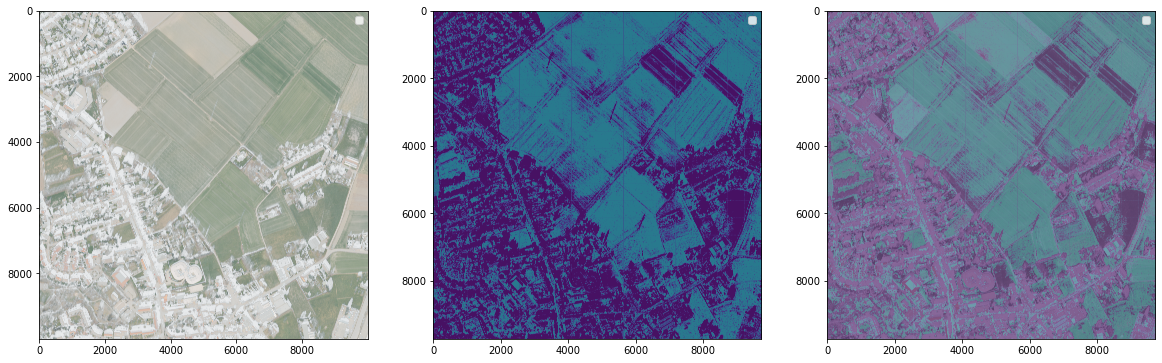

In [ ]:
fig , ax = plt.subplots(nrows=1, ncols=3, figsize=(20,10))
ax[0].imshow(original_img, label='Original image')
ax[1].imshow(test_resulr, label='Predicted mask')
ax[2].imshow(original_img, label='Predicted mask')
ax[2].imshow(test_resulr, label='Overlaping the image with orignal', alpha=0.6)
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.legend()

In [ ]:
#Checking them the hab 
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=4,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

### Tesing the model 

In [ ]:
saved_M = torch.load('/content/drive/MyDrive/Hack23/images/dataset/semantic_drone_dataset/label_images_semantic/')
save_model = torch.load('/content/drive/MyDrive/Hack23/images/dataset/semantic_drone_dataset/original_images/')

In [ ]:
model = torch.load('/content/drive/MyDrive/Hack23/Unet-Mobilenet_v2_mIoU-0.439.pt')

RuntimeError: ignored

In [ ]:
summary(model, input_size=(4, 256, 256))

#### Selecting the device 

In [ ]:
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
DEVICE = torch.device(DEVICE)
print(DEVICE)

# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

# base path of the dataset
DATASET_PATH = os.path.join("dataset", "train")

# define the path to the images and masks dataset
IMAGE_DATASET_PATH = os.path.join(DATASET_PATH, "images")
MASK_DATASET_PATH = os.path.join(DATASET_PATH, "masks")

# define the test split
TEST_SPLIT = 0.15

# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 1
NUM_CLASSES = 1

# initialize learning rate, number of epochs to train for, and the
# batch size
LR = 0.001
NUM_EPOCHS = 40
BATCH_SIZE = 64

### Data setup

In [ ]:
!pip install numpy; pip install -I --no-binary rasterio rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached rasterio-1.3.6.tar.gz (408 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached attrs-22.2.0-py3-none-any.whl (60 kB)
  Using cached certifi-2022.12.7-py3-none-any.whl (155 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
  Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
  Using cached numpy-1.24.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Using cached click-8.1.3-py3-none-any.whl (96 kB)
  Using cached setuptools-67.4.0-py3-none-any.whl (1.1 MB)
  Using cached affine-2.4.0-py3-none-any.whl (15 kB)
  Using cached snuggs-1.4.7-py3-none-any.whl (5.4 kB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
  Created wheel for ra

### Load images

In [ ]:
path_to_jp2_image = "/content/dop10rgbi_32_287_5661_1_nw_2021.jp2"

In [ ]:
def read_jp2(path_to_jp2_image, four_channels=True):
  ''' 
  Gets the image path and returns a numpy array with three/four channels of shape (channels, 10000, 10000)
  '''
  ds = rasterio.open(path_to_jp2_image)
  if four_channels:
    img = ds.read((1,2,3,4))
  else:
    img = ds.read((1,2,3))

  return img

In [ ]:
img_4_channels = read_jp2(path_to_jp2_image, four_channels=True)
# img_3_channels = read_jp2(path_to_jp2_image, four_channels=False)

In [ ]:
img_4_channels.shape

(4, 10000, 10000)

In [ ]:
def image_tiler(src, tile_size=256):
  '''
  Returns a numpy array with len(img_length/tile_size).
  Each row contains img_length/tile size tiles)
  '''
  # Calculate the number of tiles in each dimension
  num_tiles_x = src.shape[2] // tile_size
  num_tiles_y = src.shape[1] // tile_size

  result = list()

  # Loop through the image and create tiles
  for tile_x in range(num_tiles_x):
    interme_result = list()
    for tile_y in range(num_tiles_y):
        # Calculate the slice indices for this tile
        x_slice = slice(tile_x*tile_size, (tile_x+1)*tile_size)
        y_slice = slice(tile_y*tile_size, (tile_y+1)*tile_size)

        # Slice the array to get this tile
        tile = src[:, y_slice, x_slice]
        interme_result.append(tile)
    result.append(interme_result)

  return result


tiled_image = image_tiler(img_4_channels)

In [ ]:
def image_tiler(src, tile_size=256):
  '''
  Returns a numpy array with len(img_length/tile_size).
  Each row contains img_length/tile size tiles)
  '''
  # Calculate the number of tiles in each dimension
  num_tiles_x = src.shape[2] // tile_size
  num_tiles_y = src.shape[1] // tile_size

  result = list()

  # Loop through the image and create tiles
  for tile_x in range(num_tiles_x):
    interme_result = list()
    for tile_y in range(num_tiles_y):
        # Calculate the slice indices for this tile
        x_slice = slice(tile_x*tile_size, (tile_x+1)*tile_size)
        y_slice = slice(tile_y*tile_size, (tile_y+1)*tile_size)

        # Slice the array to get this tile
        tile = src[:, y_slice, x_slice]
        interme_result.append(tile)
    result.append(interme_result)

  return result

def create_mask(poly, im_height, im_width):
    # set_trace()
    ## assuming binary_mask is a numpy array with shape (height, width, channels)
    binary_mask = maskUtils.decode(maskUtils.frPyObjects(poly, im_height, im_width))
    print("This is the binary shape", binary_mask.shape)
    # grayscale_mask = np.mean(binary_mask, axis=2)

    grayscale_mask_transposed =np.transpose(binary_mask, [2,0,1])
    return grayscale_mask_transposed
    # img = Image.fromarray(np.uint8(grayscale_mask * 255), mode='L')
    # return img



def Get_COCO_Data(imgpath, anno_path=None, dst:str=None, class_name="asphalt", category_id = 0, output_size:int=256):
    """
    This function create a binary susing polygone information 

    """
    if not os.path.isdir(dst):
        raise NotADirectoryError("The input need to be an existing directory")
    
    with open(anno_path, 'r') as f:
        results = json.load(f)
    
    for image, annotation in zip(results['images'],results["annotations"]):

        im_width = image["width"]
        im_height = image["height"]
        im_id = image["id"]
        im_stem = Path(image["file_name"]).stem
        im_name = Path(image["file_name"]).name
        im_extend = Path(image["file_name"]).suffix
        im_mask = im_name + '_mask'


       
        if annotation["category_id"] ==category_id:
            poly = annotation["segmentation"]
            im_mask = create_mask(poly, im_height=im_height, im_width=im_width)
        else : # only dark image 
            array = np.zeros((im_height, im_width))
            im_mask = Image.fromarray(np.uint8(array),mode='L')


        
        #reading the Image Daniel
        ############ start ###########
        path_to_image = os.path.join(imgpath, im_stem+'.jp2')
        img_array = read_jp2(path_to_image)
        #### END #######################
        #Creating the binary mask 
        # if the match the given class 

        ################## tiling the image #######################
        tiled_image = image_tiler(img_array)
        tiled_mask = image_tiler(im_mask)
        ###################### end tiling #########################

        ################# saving the tiled (images and mask)
        # Define the output filename for this tile
        tiled_img_out = im_name+".npy"
        tiled_mask_out = im_name+"_mask.npy"

        # Save the tile to disk
        if dst != None:
          tiled_img_out = os.path.join(dst, tiled_img_out)
          tiled_mask_out = os.path.join(dst, tiled_mask_out)
        np.save(tiled_img_out, tiled_image)
        np.save(tiled_mask_out, tiled_mask)



In [ ]:
# !mkdir /content/drive/MyDrive/Hack23/distination
!mkdir /content/distination

In [ ]:
im_path = "/content/drive/MyDrive/Hack23/"
im_dst  = "/content/drive/MyDrive/Hack23/distination/"
ann_path = "/content/drive/MyDrive/Hack23/result.json"

In [ ]:
im_path = "/content/"
im_dst  = "/content/"
ann_path = "/content/result.json"

In [ ]:
Get_COCO_Data(imgpath=im_path, anno_path=ann_path, dst=im_dst, class_name="asphalt", category_id = 0, output_size=256)

In [ ]:
batch_1 = np.load("/content/dop10rgbi_32_287_5661_1_nw_2021.jpeg.npy")

In [ ]:
batch_1 = np.load("/content/drive/MyDrive/Hack23/distination/dop10rgbi_32_287_5661_1_nw_2021.jpeg.npy")

In [ ]:
batch_1.tolist()

In [ ]:
image_list1 = tiled_image # batch_1.tolist()

In [ ]:
tiled_image

[array([[[152, 150, 148, ..., 133, 133, 134],
         [148, 147, 146, ..., 131, 132, 132],
         [145, 145, 145, ..., 130, 131, 130],
         ...,
         [153, 150, 148, ..., 138, 149, 150],
         [150, 148, 146, ..., 145, 144, 144],
         [147, 145, 144, ..., 150, 149, 147]],
 
        [[140, 133, 127, ..., 133, 134, 135],
         [135, 131, 127, ..., 131, 133, 133],
         [131, 129, 127, ..., 130, 132, 132],
         ...,
         [122, 126, 131, ..., 133, 136, 137],
         [139, 134, 130, ..., 129, 130, 130],
         [133, 131, 129, ..., 135, 134, 133]],
 
        [[121, 119, 117, ..., 106, 106, 106],
         [111, 111, 111, ..., 105, 105, 105],
         [101, 103, 106, ..., 105, 105, 104],
         ...,
         [106, 109, 113, ..., 103, 113, 116],
         [123, 115, 109, ..., 108, 104, 108],
         [117, 113, 109, ..., 114, 112, 113]],
 
        [[141, 141, 141, ..., 170, 170, 171],
         [137, 138, 140, ..., 168, 168, 169],
         [133, 136, 139, ...,

In [ ]:
len(image_list1),len(image_list1[0]), len(image_list1[0][0]), type(image_list1[0]), type(image_list1[0][0]), len(image_list1[0][0][0])

(39, 39, 4, list, numpy.ndarray, 256)

In [ ]:
concatenated = np.concatenate(image_list1, axis=1)
combined_array = concatenated.reshape(39 * 256, 39 * 256, 4)

combined_array.shape

(9984, 9984, 4)

In [ ]:
np.array(np.array([[1,2], [2,2]]).flatten()

array([1, 2, 2, 2])

(9984, 9984, 4)

In [ ]:
combined_array

AttributeError: ignored

In [ ]:
type(combined_array)

numpy.ndarray

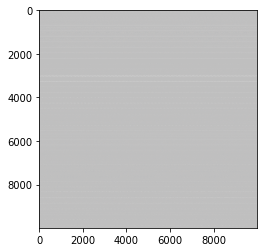

In [ ]:
plt.imshow(combined_array)

In [ ]:
batch_1_mask = np.load("/content/drive/MyDrive/Hack23/distination/dop10rgbi_32_287_5661_1_nw_2021.jpeg_mask.npy")

In [ ]:
image_list1_mask = batch_1_mask.tolist()

ValueError: ignored

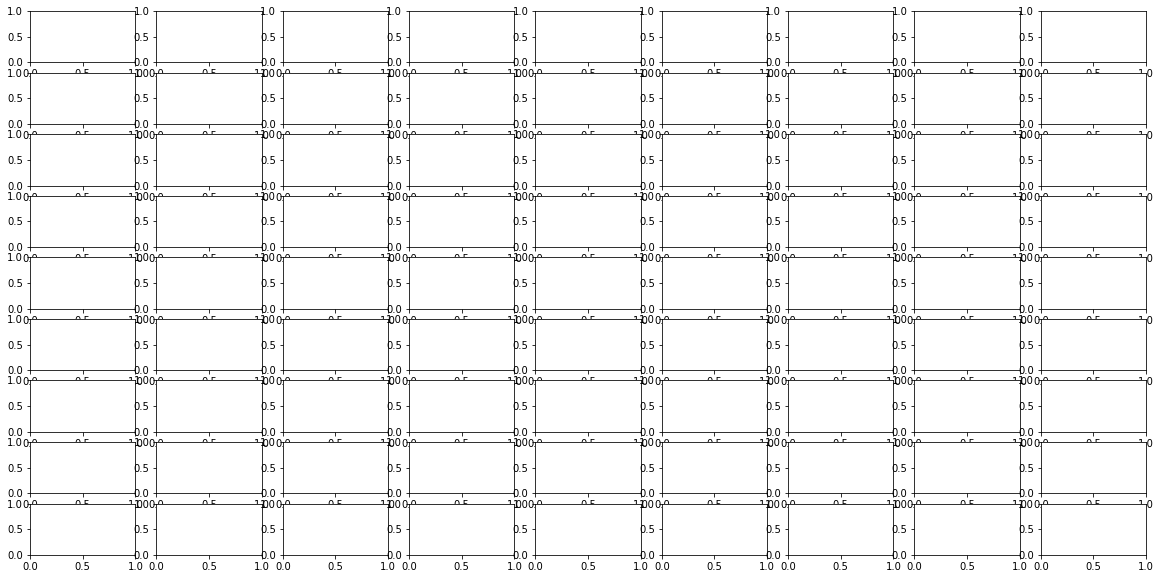

In [ ]:
fig , ax = plt.subplots(nrows=9, ncols=9, figsize=(20,10))
for i in range(9):
  for j in range(9):
    img_tmp = np.array(combined_array[i][j])
    img_tmp = np.uint8(img_tmp)
    img_tmp = np.transpose(img_tmp, [1,2,0])
    # print(type(img_tmp))
    img_tmp = img_tmp[:, :,0:3]
    # img_tmp = np.transpose(img_tmp, axes=[2,1,0])
    ax[i,j].imshow(img_tmp)

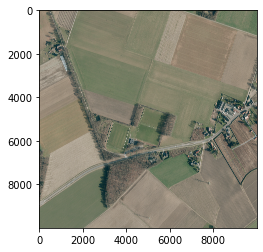

In [ ]:
# plot an example image
tmp = np.transpose(img_3_channels, axes=[2,1,0])
plt.imshow(tmp)

### Load masks

In [ ]:
# load masks
mask_4_channels = ""
mask_3_channels = ""

### Tile images and masks

In [ ]:
tiled_img_4_channels = image_tiler(img_4_channels)
tiled_img_3_channels = image_tiler(img_3_channels)

# tiled_mask_4_channels = image_tiler()
# tiled_mask_3_channels = image_tiler()

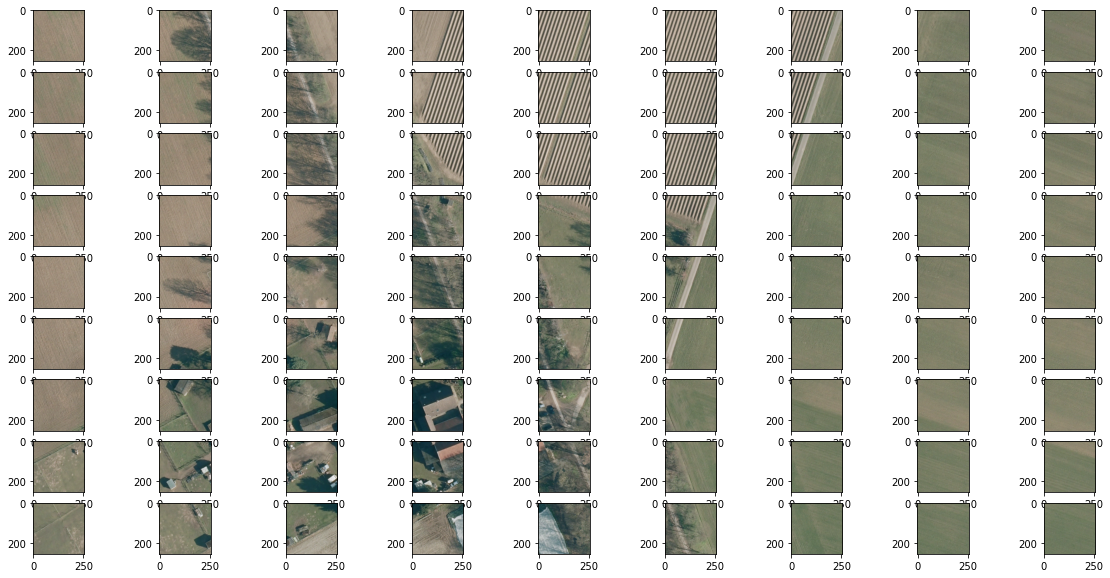

In [ ]:
fig , ax = plt.subplots(nrows=9, ncols=9, figsize=(20,10))
for i in range(9):
  for j in range(9):
    img_tmp = tiled_img_3_channels[i][j]

    img_tmp = np.transpose(img_tmp, axes=[2,1,0])
    ax[i,j].imshow(img_tmp)


In [ ]:
# Define the output filename for this tile
tiled_img_out = "tile_img.npy"
tiled_mask_out = "tile_mask.npy"

# Save the tile to disk
np.save(tiled_img_out, tiled_img_4_channels)
# np.save(tiled_mask_out, tiled_mask_4_channels)

### Dataloader

In [ ]:
def get_transforms():
  return transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                 [0.485, 0.456, 0.406], 
                                 [0.229, 0.224, 0.225]
                                 )
                             ])


In [ ]:
class AareasData(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=True, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
            

        if self.transform is None:
            img = Image.fromarray(img)
        
        t = transforms.Compose([transforms.ToTensor(), transforms.Normalize(self.mean, self.std)])
        img = t(img)
        
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
        return img, mask
    
    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)

        img_patches  = img_patches.contiguous().view(3,-1, 512, 768)

        img_patches = img_patches.permute(1,0,2,3)

        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

In [ ]:
class SurfaceAIDataset(Dataset):
    
	def __init__(self, image_paths, mask_paths, transforms):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.image_paths = image_paths
		self.mask_paths = mask_paths
		self.transforms = transforms
  
	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.image_paths)

	def __getitem__(self, idx):
    # grab the image path from the current index
		image_path = self.image_paths[idx]
		
    # load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(image_path)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		mask = cv2.imread(self.mask_paths[idx], 0)
		
    # check to see if we are applying any transformations
		if self.transforms is not None:
			# apply the transformations to both image and its mask
			image = self.transforms(image)
			mask = self.transforms(mask)
		
    # return a tuple of the image and its mask
		return (image, mask)

In [ ]:
# load the image and mask filepaths in a sorted manner
image_paths = sorted(list(paths.list_images(IMAGE_DATASET_PATH)))
mask_paths = sorted(list(paths.list_images(MASK_DATASET_PATH)))

# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
split = train_test_split(image_paths, mask_paths,
	test_size=TEST_SIZE, random_state=42)

# unpack the data split
(train_images, test_images) = split[:2]
(train_masks, test_masks) = split[2:]

# write the testing image paths to disk so that we can use then
# when evaluating/testing our model
# print("[INFO] saving testing image paths...")
# f = open(...), "w")
# f.write("\n".join(test_images))
# f.close()

In [ ]:
# define transformations
transforms = transforms.Compose([transforms.ToPILImage(),
 	transforms.Resize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
	transforms.ToTensor()])

# create the train and test datasets
train_ds = SurfaceAIDataset(image_paths=train_images, mask_paths=train_masks,
	transforms=transforms)
test_ds = SurfaceAIDataset(image_paths=test_images, mask_paths=test_masks,
    transforms=transforms)
print(f"[INFO] found {len(train_ds)} examples in the training set...")
print(f"[INFO] found {len(test_ds)} examples in the test set...")

# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True,
	batch_size=BATCH_SIZE)
testLoader = DataLoader(testDS, shuffle=False,
	batch_size=BATCH_SIZE)

### Model building

In [ ]:
## Setting up the models 

In [ ]:
""" Full assembly of the parts to form the complete network """

""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet_back(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet_back, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64)) 
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

class UNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size=3):
        """
        This function creates one contracting block
        """
        block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                )
        return block

    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
        """
        This function creates one expansive block
        """
        block = torch.nn.Sequential(
                torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(mid_channel),
                torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(mid_channel),
                torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
                )
        return  block

    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
        """
        This returns final block
        """
        block = torch.nn.Sequential(
                torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(mid_channel),
                torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(mid_channel),
                torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1),
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(out_channels),
                )
        return  block

    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        #Encode
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=64)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode2 = self.contracting_block(64, 128)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode3 = self.contracting_block(128, 256)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        # Bottleneck
        self.bottleneck = torch.nn.Sequential(
                            torch.nn.Conv2d(kernel_size=3, in_channels=256, out_channels=512),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.Conv2d(kernel_size=3, in_channels=512, out_channels=512),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
                            )
        # Decode
        self.conv_decode3 = self.expansive_block(512, 256, 128)
        self.conv_decode2 = self.expansive_block(256, 128, 64)
        self.final_layer = self.final_block(128, 64, out_channel)

    def crop_and_concat(self, upsampled, bypass, crop=False):
        """
        This layer crop the layer from contraction block and concat it with expansive block vector
        """
        # if crop:
        #     c = (bypass.size()[2] - upsampled.size()[2]) // 2
        #     bypass = F.pad(bypass, (-c, -c, -c, -c))
        # return torch.cat((upsampled, bypass), 1)

        if crop:
          diffY = upsampled.size()[2] - bypass.size()[2]
          diffX = upsampled.size()[3] - bypass.size()[3]

          c = (bypass.size()[2] - upsampled.size()[2]) // 2
          print("After croped", c)
          bypass = F.pad(bypass, [diffX // 2, diffX - diffX // 2,
                      diffY // 2, diffY - diffY // 2])
          print(f"upsample{upsampled.size()} -- bypass{bypass.size()} ")
        return torch.cat((upsampled, bypass), 1)

    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool3)
        # Decode
        decode_block3 = self.crop_and_concat(bottleneck1, encode_block3, crop=True)
        cat_layer2 = self.conv_decode3(decode_block3)
        decode_block2 = self.crop_and_concat(cat_layer2, encode_block2, crop=True)
        cat_layer1 = self.conv_decode2(decode_block2)
        decode_block1 = self.crop_and_concat(cat_layer1, encode_block1, crop=True)
        final_layer = self.final_layer(decode_block1)
        print("Final size", final_layer.size())
        return  final_layer

In [ ]:
from torchsummary import summary

In [ ]:
from torchsummary import summary
model = UNet_back(n_channels=4, n_classes=1, bilinear=False)

In [ ]:
summary(model, input_size=(4, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           2,304
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,864
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
        DoubleConv-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,728
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,456
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1